# Pleiothropy all tasks

#### Data Preprocessing:
- merge all pedgree ID's 
- build a unique Pedigree
- merge all pheno files according the unique pedgree

#### Pleiothropy estimate:
- loop over pheno and estimate pleiothropy between each pair of pheno
- collect results in a dictionary of matrix:
    - pleio Matrix rhoG
    - P-value Matrix of rhoG different from 0
    - P-value Matrix of rhoG d
    ifferent from 1
    - pleio Matrix RhoE
    - P-value Matrix of RhoE different from 0
    - P-value Matrix of RhoE different from 1

#### Clutering Rho Matrices :
- cluster pleio Matrix rhoG
- plot clustered pleio Matrix rhoG
- plot clustered P-value Matrix of rhoG different from 0
- plot clustered P-value Matrix of rhoG different from 1
- cluster pleio Matrix RhoE
- plot clustered pleio Matrix RhoE
- plot clustered P-value Matrix of RhoE different from 0
- plot clustered P-value Matrix of RhoE different from 1

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns
import functools
import subprocess as subp
from nilearn import plotting as nlp
from scipy import cluster as scl
from scipy import io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec as gs
import itertools
import datetime
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import collections
import multiprocessing 
import datetime


/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in sta

In [2]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [3]:
%matplotlib inline

In [4]:
# Set path 
#path_root = '/media/yassine/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_root = '/scratch/yassinebha/pleio/'

# Load files
pedig_df = pd.read_csv(os.path.join(path_root,'pleio_all_pheno_pedig.csv'))
pheno_df =  pd.read_csv(os.path.join(path_root,'hcp_all_pheno_clean_nonan_norm.csv'),
                        dtype={'Unnamed: 0':str}).rename(columns={'Unnamed: 0' : 'ID'})

# add HCP prefix to pheno file ID's
pheno_df['ID'] = ['HCP'+row.ID for idx,row in pheno_df.iterrows()]

In [5]:
# clean pheno file according to pedig file
pheno_clean_df = pd.merge(pedig_df[['ID']],pheno_df.drop(columns=['Handedness', 'Odor_Unadj']),how='left',on='ID').dropna()

pheno_clean_df.head()

,ID,SSAGA_Educ,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100206,0.640665,-0.055687,-0.391613,-0.586484,0.251477,1.012772,0.414128,1.808004,0.733950,...,0.598684,1.129563,2.036715,1.146888,2.254271,1.501363,2.590293,2.105813,1.602376,0.819715
1,HCP100307,0.640665,-0.712932,-0.528777,-0.677497,-0.743000,-0.048759,0.862312,0.023611,0.118864,...,-0.560381,-0.681798,-0.885736,-0.323938,-0.682909,-0.624284,-0.684158,-0.707406,-0.659096,-0.431086
2,HCP100408,0.640665,0.142558,1.871597,1.506814,-0.080015,1.059755,-0.363632,0.884836,-1.931424,...,0.405506,-0.681798,-0.980008,-0.210797,-0.682909,-0.431043,-0.684158,-0.707406,-0.659096,-0.431086
3,HCP100610,0.640665,1.778527,1.117194,-0.222433,-0.080015,-0.164015,1.454382,1.419354,1.349037,...,-0.753559,-0.138390,0.434081,-0.323938,-0.682909,-0.624284,-0.684158,2.602263,-0.833056,-0.639553
4,HCP101006,-1.545133,0.592628,0.362791,0.869723,-0.743000,-1.952321,-0.942091,-1.046425,-1.111309,...,-0.367204,-0.681798,-1.168554,-0.210797,-0.682909,-0.624284,-0.684158,-0.707406,-0.833056,-0.639553


In [6]:
# Save pheno clean 
pheno_clean_df.to_csv(os.path.join(path_root,'hcp_all_pheno_clean_nonan_norm_pleio.csv'),index=False)

### Pleiothropy estimate:

In [7]:
#initiate empty dictionary
Pleio_RhoG = collections.namedtuple('Pleio_RhoG', ['out_dir',
                                                   'pedig_f',
                                                   'pheno_f',
                                                   'var_1',
                                                   'var_2'
                                                  ])
pleio_RhoGs = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}'.format(str(datetime.date.today())))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        print(pheno_1,pheno_2)
        
        # output result folder 
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        if not os.path.exists(path_pleio_contrast):
            os.makedirs(path_pleio_contrast)
            
        # copy needed files to output folder
        if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
            subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_pheno_run.sh')):
            subp.run(['cp',os.path.join(path_root,'pleio_pheno_run.sh'),path_pleio_contrast])
            
        # pedegree
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')):
            subp.run(['cp',os.path.join(path_root,'pleio_all_pheno_pedig.csv'),path_pleio_contrast]) 
            
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        
        # pheno cov stack
        df_pheno = pheno_clean_df[['ID',pheno_1,pheno_2]]
        #cov_1 = '{}_FD_scrubbed_mean'.format(pheno_1.split('_')[0])
        #cov_2 = '{}_FD_scrubbed_mean'.format(pheno_2.split('_')[0])
        #df_cov = cov_stack_FD_df[['ID',cov_1,cov_2]]
        #pheno_cov_stack = [df_pheno,df_cov,cov_stack_stand_df]
        
        # merge pheno cov
        #pheno_cov_df = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), 
        #                                pheno_cov_stack)
        # save pheno cov to file
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        if not os.path.isfile(pheno_f):
            df_pheno.to_csv(pheno_f,index=False)   
        
        # collect all pleio contrasts in dictionary
        pleio_RhoGs.append(Pleio_RhoG(out_dir = path_pleio_contrast,
                                      pedig_f = pedig_f,
                                      pheno_f = pheno_f,
                                      var_1 = pheno_1,
                                      var_2 = pheno_2)) 

SSAGA_Educ BMI
SSAGA_Educ BPSystolic
SSAGA_Educ BPDiastolic
SSAGA_Educ PSQI_Score
SSAGA_Educ PicSeq_Unadj
SSAGA_Educ CardSort_Unadj
SSAGA_Educ Flanker_Unadj
SSAGA_Educ PMAT24_A_CR
SSAGA_Educ PMAT24_A_RTCR
SSAGA_Educ ReadEng_Unadj
SSAGA_Educ PicVocab_Unadj
SSAGA_Educ ProcSpeed_Unadj
SSAGA_Educ DDisc_AUC_200
SSAGA_Educ DDisc_AUC_40K
SSAGA_Educ VSPLOT_TC
SSAGA_Educ VSPLOT_CRTE
SSAGA_Educ SCPT_TP
SSAGA_Educ SCPT_TN
SSAGA_Educ SCPT_TPRT
SSAGA_Educ IWRD_TOT
SSAGA_Educ IWRD_RTC
SSAGA_Educ ER40_CR
SSAGA_Educ ER40_CRT
SSAGA_Educ Sadness_Unadj
SSAGA_Educ FearSomat_Unadj
SSAGA_Educ FearAffect_Unadj
SSAGA_Educ AngAggr_Unadj
SSAGA_Educ AngHostil_Unadj
SSAGA_Educ AngAffect_Unadj
SSAGA_Educ LifeSatisf_Unadj
SSAGA_Educ MeanPurp_Unadj
SSAGA_Educ PosAffect_Unadj
SSAGA_Educ Friendship_Unadj
SSAGA_Educ Loneliness_Unadj
SSAGA_Educ PercHostil_Unadj
SSAGA_Educ PercReject_Unadj
SSAGA_Educ EmotSupp_Unadj
SSAGA_Educ InstruSupp_Unadj
SSAGA_Educ PercStress_Unadj
SSAGA_Educ SelfEff_Unadj
SSAGA_Educ PainInterf_Tsco

Flanker_Unadj ProcSpeed_Unadj
Flanker_Unadj DDisc_AUC_200
Flanker_Unadj DDisc_AUC_40K
Flanker_Unadj VSPLOT_TC
Flanker_Unadj VSPLOT_CRTE
Flanker_Unadj SCPT_TP
Flanker_Unadj SCPT_TN
Flanker_Unadj SCPT_TPRT
Flanker_Unadj IWRD_TOT
Flanker_Unadj IWRD_RTC
Flanker_Unadj ER40_CR
Flanker_Unadj ER40_CRT
Flanker_Unadj Sadness_Unadj
Flanker_Unadj FearSomat_Unadj
Flanker_Unadj FearAffect_Unadj
Flanker_Unadj AngAggr_Unadj
Flanker_Unadj AngHostil_Unadj
Flanker_Unadj AngAffect_Unadj
Flanker_Unadj LifeSatisf_Unadj
Flanker_Unadj MeanPurp_Unadj
Flanker_Unadj PosAffect_Unadj
Flanker_Unadj Friendship_Unadj
Flanker_Unadj Loneliness_Unadj
Flanker_Unadj PercHostil_Unadj
Flanker_Unadj PercReject_Unadj
Flanker_Unadj EmotSupp_Unadj
Flanker_Unadj InstruSupp_Unadj
Flanker_Unadj PercStress_Unadj
Flanker_Unadj SelfEff_Unadj
Flanker_Unadj PainInterf_Tscore
Flanker_Unadj Taste_Unadj
Flanker_Unadj Mars_Final
Flanker_Unadj Endurance_Unadj
Flanker_Unadj GaitSpeed_Comp
Flanker_Unadj Dexterity_Unadj
Flanker_Unadj Strength_

PicVocab_Unadj ASR_Thot_Pct
PicVocab_Unadj ASR_Attn_Pct
PicVocab_Unadj ASR_Aggr_Pct
PicVocab_Unadj ASR_Rule_Pct
PicVocab_Unadj ASR_Intr_Pct
PicVocab_Unadj ASR_Intn_T
PicVocab_Unadj ASR_Extn_T
PicVocab_Unadj DSM_Depr_Pct
PicVocab_Unadj DSM_Anxi_Pct
PicVocab_Unadj DSM_Somp_Pct
PicVocab_Unadj DSM_Avoid_Pct
PicVocab_Unadj DSM_Adh_Pct
PicVocab_Unadj DSM_Antis_Pct
ProcSpeed_Unadj SSAGA_Educ
ProcSpeed_Unadj BMI
ProcSpeed_Unadj BPSystolic
ProcSpeed_Unadj BPDiastolic
ProcSpeed_Unadj PSQI_Score
ProcSpeed_Unadj PicSeq_Unadj
ProcSpeed_Unadj CardSort_Unadj
ProcSpeed_Unadj Flanker_Unadj
ProcSpeed_Unadj PMAT24_A_CR
ProcSpeed_Unadj PMAT24_A_RTCR
ProcSpeed_Unadj ReadEng_Unadj
ProcSpeed_Unadj PicVocab_Unadj
ProcSpeed_Unadj DDisc_AUC_200
ProcSpeed_Unadj DDisc_AUC_40K
ProcSpeed_Unadj VSPLOT_TC
ProcSpeed_Unadj VSPLOT_CRTE
ProcSpeed_Unadj SCPT_TP
ProcSpeed_Unadj SCPT_TN
ProcSpeed_Unadj SCPT_TPRT
ProcSpeed_Unadj IWRD_TOT
ProcSpeed_Unadj IWRD_RTC
ProcSpeed_Unadj ER40_CR
ProcSpeed_Unadj ER40_CRT
ProcSpeed_Unad

VSPLOT_CRTE GaitSpeed_Comp
VSPLOT_CRTE Dexterity_Unadj
VSPLOT_CRTE Strength_Unadj
VSPLOT_CRTE NEOFAC_A
VSPLOT_CRTE NEOFAC_O
VSPLOT_CRTE NEOFAC_C
VSPLOT_CRTE NEOFAC_N
VSPLOT_CRTE NEOFAC_E
VSPLOT_CRTE ASR_Anxd_Pct
VSPLOT_CRTE ASR_Witd_Pct
VSPLOT_CRTE ASR_Soma_Pct
VSPLOT_CRTE ASR_Thot_Pct
VSPLOT_CRTE ASR_Attn_Pct
VSPLOT_CRTE ASR_Aggr_Pct
VSPLOT_CRTE ASR_Rule_Pct
VSPLOT_CRTE ASR_Intr_Pct
VSPLOT_CRTE ASR_Intn_T
VSPLOT_CRTE ASR_Extn_T
VSPLOT_CRTE DSM_Depr_Pct
VSPLOT_CRTE DSM_Anxi_Pct
VSPLOT_CRTE DSM_Somp_Pct
VSPLOT_CRTE DSM_Avoid_Pct
VSPLOT_CRTE DSM_Adh_Pct
VSPLOT_CRTE DSM_Antis_Pct
SCPT_TP SSAGA_Educ
SCPT_TP BMI
SCPT_TP BPSystolic
SCPT_TP BPDiastolic
SCPT_TP PSQI_Score
SCPT_TP PicSeq_Unadj
SCPT_TP CardSort_Unadj
SCPT_TP Flanker_Unadj
SCPT_TP PMAT24_A_CR
SCPT_TP PMAT24_A_RTCR
SCPT_TP ReadEng_Unadj
SCPT_TP PicVocab_Unadj
SCPT_TP ProcSpeed_Unadj
SCPT_TP DDisc_AUC_200
SCPT_TP DDisc_AUC_40K
SCPT_TP VSPLOT_TC
SCPT_TP VSPLOT_CRTE
SCPT_TP SCPT_TN
SCPT_TP SCPT_TPRT
SCPT_TP IWRD_TOT
SCPT_TP IWRD_RTC


FearSomat_Unadj Friendship_Unadj
FearSomat_Unadj Loneliness_Unadj
FearSomat_Unadj PercHostil_Unadj
FearSomat_Unadj PercReject_Unadj
FearSomat_Unadj EmotSupp_Unadj
FearSomat_Unadj InstruSupp_Unadj
FearSomat_Unadj PercStress_Unadj
FearSomat_Unadj SelfEff_Unadj
FearSomat_Unadj PainInterf_Tscore
FearSomat_Unadj Taste_Unadj
FearSomat_Unadj Mars_Final
FearSomat_Unadj Endurance_Unadj
FearSomat_Unadj GaitSpeed_Comp
FearSomat_Unadj Dexterity_Unadj
FearSomat_Unadj Strength_Unadj
FearSomat_Unadj NEOFAC_A
FearSomat_Unadj NEOFAC_O
FearSomat_Unadj NEOFAC_C
FearSomat_Unadj NEOFAC_N
FearSomat_Unadj NEOFAC_E
FearSomat_Unadj ASR_Anxd_Pct
FearSomat_Unadj ASR_Witd_Pct
FearSomat_Unadj ASR_Soma_Pct
FearSomat_Unadj ASR_Thot_Pct
FearSomat_Unadj ASR_Attn_Pct
FearSomat_Unadj ASR_Aggr_Pct
FearSomat_Unadj ASR_Rule_Pct
FearSomat_Unadj ASR_Intr_Pct
FearSomat_Unadj ASR_Intn_T
FearSomat_Unadj ASR_Extn_T
FearSomat_Unadj DSM_Depr_Pct
FearSomat_Unadj DSM_Anxi_Pct
FearSomat_Unadj DSM_Somp_Pct
FearSomat_Unadj DSM_Avoid_Pc

AngAffect_Unadj DSM_Somp_Pct
AngAffect_Unadj DSM_Avoid_Pct
AngAffect_Unadj DSM_Adh_Pct
AngAffect_Unadj DSM_Antis_Pct
LifeSatisf_Unadj SSAGA_Educ
LifeSatisf_Unadj BMI
LifeSatisf_Unadj BPSystolic
LifeSatisf_Unadj BPDiastolic
LifeSatisf_Unadj PSQI_Score
LifeSatisf_Unadj PicSeq_Unadj
LifeSatisf_Unadj CardSort_Unadj
LifeSatisf_Unadj Flanker_Unadj
LifeSatisf_Unadj PMAT24_A_CR
LifeSatisf_Unadj PMAT24_A_RTCR
LifeSatisf_Unadj ReadEng_Unadj
LifeSatisf_Unadj PicVocab_Unadj
LifeSatisf_Unadj ProcSpeed_Unadj
LifeSatisf_Unadj DDisc_AUC_200
LifeSatisf_Unadj DDisc_AUC_40K
LifeSatisf_Unadj VSPLOT_TC
LifeSatisf_Unadj VSPLOT_CRTE
LifeSatisf_Unadj SCPT_TP
LifeSatisf_Unadj SCPT_TN
LifeSatisf_Unadj SCPT_TPRT
LifeSatisf_Unadj IWRD_TOT
LifeSatisf_Unadj IWRD_RTC
LifeSatisf_Unadj ER40_CR
LifeSatisf_Unadj ER40_CRT
LifeSatisf_Unadj Sadness_Unadj
LifeSatisf_Unadj FearSomat_Unadj
LifeSatisf_Unadj FearAffect_Unadj
LifeSatisf_Unadj AngAggr_Unadj
LifeSatisf_Unadj AngHostil_Unadj
LifeSatisf_Unadj AngAffect_Unadj
LifeSat

Loneliness_Unadj GaitSpeed_Comp
Loneliness_Unadj Dexterity_Unadj
Loneliness_Unadj Strength_Unadj
Loneliness_Unadj NEOFAC_A
Loneliness_Unadj NEOFAC_O
Loneliness_Unadj NEOFAC_C
Loneliness_Unadj NEOFAC_N
Loneliness_Unadj NEOFAC_E
Loneliness_Unadj ASR_Anxd_Pct
Loneliness_Unadj ASR_Witd_Pct
Loneliness_Unadj ASR_Soma_Pct
Loneliness_Unadj ASR_Thot_Pct
Loneliness_Unadj ASR_Attn_Pct
Loneliness_Unadj ASR_Aggr_Pct
Loneliness_Unadj ASR_Rule_Pct
Loneliness_Unadj ASR_Intr_Pct
Loneliness_Unadj ASR_Intn_T
Loneliness_Unadj ASR_Extn_T
Loneliness_Unadj DSM_Depr_Pct
Loneliness_Unadj DSM_Anxi_Pct
Loneliness_Unadj DSM_Somp_Pct
Loneliness_Unadj DSM_Avoid_Pct
Loneliness_Unadj DSM_Adh_Pct
Loneliness_Unadj DSM_Antis_Pct
PercHostil_Unadj SSAGA_Educ
PercHostil_Unadj BMI
PercHostil_Unadj BPSystolic
PercHostil_Unadj BPDiastolic
PercHostil_Unadj PSQI_Score
PercHostil_Unadj PicSeq_Unadj
PercHostil_Unadj CardSort_Unadj
PercHostil_Unadj Flanker_Unadj
PercHostil_Unadj PMAT24_A_CR
PercHostil_Unadj PMAT24_A_RTCR
PercHosti

InstruSupp_Unadj DSM_Anxi_Pct
InstruSupp_Unadj DSM_Somp_Pct
InstruSupp_Unadj DSM_Avoid_Pct
InstruSupp_Unadj DSM_Adh_Pct
InstruSupp_Unadj DSM_Antis_Pct
PercStress_Unadj SSAGA_Educ
PercStress_Unadj BMI
PercStress_Unadj BPSystolic
PercStress_Unadj BPDiastolic
PercStress_Unadj PSQI_Score
PercStress_Unadj PicSeq_Unadj
PercStress_Unadj CardSort_Unadj
PercStress_Unadj Flanker_Unadj
PercStress_Unadj PMAT24_A_CR
PercStress_Unadj PMAT24_A_RTCR
PercStress_Unadj ReadEng_Unadj
PercStress_Unadj PicVocab_Unadj
PercStress_Unadj ProcSpeed_Unadj
PercStress_Unadj DDisc_AUC_200
PercStress_Unadj DDisc_AUC_40K
PercStress_Unadj VSPLOT_TC
PercStress_Unadj VSPLOT_CRTE
PercStress_Unadj SCPT_TP
PercStress_Unadj SCPT_TN
PercStress_Unadj SCPT_TPRT
PercStress_Unadj IWRD_TOT
PercStress_Unadj IWRD_RTC
PercStress_Unadj ER40_CR
PercStress_Unadj ER40_CRT
PercStress_Unadj Sadness_Unadj
PercStress_Unadj FearSomat_Unadj
PercStress_Unadj FearAffect_Unadj
PercStress_Unadj AngAggr_Unadj
PercStress_Unadj AngHostil_Unadj
PercSt

Mars_Final AngAffect_Unadj
Mars_Final LifeSatisf_Unadj
Mars_Final MeanPurp_Unadj
Mars_Final PosAffect_Unadj
Mars_Final Friendship_Unadj
Mars_Final Loneliness_Unadj
Mars_Final PercHostil_Unadj
Mars_Final PercReject_Unadj
Mars_Final EmotSupp_Unadj
Mars_Final InstruSupp_Unadj
Mars_Final PercStress_Unadj
Mars_Final SelfEff_Unadj
Mars_Final PainInterf_Tscore
Mars_Final Taste_Unadj
Mars_Final Endurance_Unadj
Mars_Final GaitSpeed_Comp
Mars_Final Dexterity_Unadj
Mars_Final Strength_Unadj
Mars_Final NEOFAC_A
Mars_Final NEOFAC_O
Mars_Final NEOFAC_C
Mars_Final NEOFAC_N
Mars_Final NEOFAC_E
Mars_Final ASR_Anxd_Pct
Mars_Final ASR_Witd_Pct
Mars_Final ASR_Soma_Pct
Mars_Final ASR_Thot_Pct
Mars_Final ASR_Attn_Pct
Mars_Final ASR_Aggr_Pct
Mars_Final ASR_Rule_Pct
Mars_Final ASR_Intr_Pct
Mars_Final ASR_Intn_T
Mars_Final ASR_Extn_T
Mars_Final DSM_Depr_Pct
Mars_Final DSM_Anxi_Pct
Mars_Final DSM_Somp_Pct
Mars_Final DSM_Avoid_Pct
Mars_Final DSM_Adh_Pct
Mars_Final DSM_Antis_Pct
Endurance_Unadj SSAGA_Educ
Enduran

NEOFAC_E ER40_CRT
NEOFAC_E Sadness_Unadj
NEOFAC_E FearSomat_Unadj
NEOFAC_E FearAffect_Unadj
NEOFAC_E AngAggr_Unadj
NEOFAC_E AngHostil_Unadj
NEOFAC_E AngAffect_Unadj
NEOFAC_E LifeSatisf_Unadj
NEOFAC_E MeanPurp_Unadj
NEOFAC_E PosAffect_Unadj
NEOFAC_E Friendship_Unadj
NEOFAC_E Loneliness_Unadj
NEOFAC_E PercHostil_Unadj
NEOFAC_E PercReject_Unadj
NEOFAC_E EmotSupp_Unadj
NEOFAC_E InstruSupp_Unadj
NEOFAC_E PercStress_Unadj
NEOFAC_E SelfEff_Unadj
NEOFAC_E PainInterf_Tscore
NEOFAC_E Taste_Unadj
NEOFAC_E Mars_Final
NEOFAC_E Endurance_Unadj
NEOFAC_E GaitSpeed_Comp
NEOFAC_E Dexterity_Unadj
NEOFAC_E Strength_Unadj
NEOFAC_E NEOFAC_A
NEOFAC_E NEOFAC_O
NEOFAC_E NEOFAC_C
NEOFAC_E NEOFAC_N
NEOFAC_E ASR_Anxd_Pct
NEOFAC_E ASR_Witd_Pct
NEOFAC_E ASR_Soma_Pct
NEOFAC_E ASR_Thot_Pct
NEOFAC_E ASR_Attn_Pct
NEOFAC_E ASR_Aggr_Pct
NEOFAC_E ASR_Rule_Pct
NEOFAC_E ASR_Intr_Pct
NEOFAC_E ASR_Intn_T
NEOFAC_E ASR_Extn_T
NEOFAC_E DSM_Depr_Pct
NEOFAC_E DSM_Anxi_Pct
NEOFAC_E DSM_Somp_Pct
NEOFAC_E DSM_Avoid_Pct
NEOFAC_E DSM_A

ASR_Intn_T DSM_Avoid_Pct
ASR_Intn_T DSM_Adh_Pct
ASR_Intn_T DSM_Antis_Pct
ASR_Extn_T SSAGA_Educ
ASR_Extn_T BMI
ASR_Extn_T BPSystolic
ASR_Extn_T BPDiastolic
ASR_Extn_T PSQI_Score
ASR_Extn_T PicSeq_Unadj
ASR_Extn_T CardSort_Unadj
ASR_Extn_T Flanker_Unadj
ASR_Extn_T PMAT24_A_CR
ASR_Extn_T PMAT24_A_RTCR
ASR_Extn_T ReadEng_Unadj
ASR_Extn_T PicVocab_Unadj
ASR_Extn_T ProcSpeed_Unadj
ASR_Extn_T DDisc_AUC_200
ASR_Extn_T DDisc_AUC_40K
ASR_Extn_T VSPLOT_TC
ASR_Extn_T VSPLOT_CRTE
ASR_Extn_T SCPT_TP
ASR_Extn_T SCPT_TN
ASR_Extn_T SCPT_TPRT
ASR_Extn_T IWRD_TOT
ASR_Extn_T IWRD_RTC
ASR_Extn_T ER40_CR
ASR_Extn_T ER40_CRT
ASR_Extn_T Sadness_Unadj
ASR_Extn_T FearSomat_Unadj
ASR_Extn_T FearAffect_Unadj
ASR_Extn_T AngAggr_Unadj
ASR_Extn_T AngHostil_Unadj
ASR_Extn_T AngAffect_Unadj
ASR_Extn_T LifeSatisf_Unadj
ASR_Extn_T MeanPurp_Unadj
ASR_Extn_T PosAffect_Unadj
ASR_Extn_T Friendship_Unadj
ASR_Extn_T Loneliness_Unadj
ASR_Extn_T PercHostil_Unadj
ASR_Extn_T PercReject_Unadj
ASR_Extn_T EmotSupp_Unadj
ASR_Extn_T I

In [51]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_pheno_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [52]:
subp.run(['bash', os.path.join(pleio_RhoGs[0].out_dir,'pleio_pheno_run.sh'),
              pleio_RhoGs[0].out_dir,
              pleio_RhoGs[0].pedig_f,
              pleio_RhoGs[0].pheno_f,
              pleio_RhoGs[0].var_1,
              pleio_RhoGs[0].var_2
         ])

CompletedProcess(args=['bash', '/scratch/yassinebha/pleio/pleio_2018-04-16/SSAGA_Educ_BMI/pleio_pheno_run.sh', '/scratch/yassinebha/pleio/pleio_2018-04-16/SSAGA_Educ_BMI', '/scratch/yassinebha/pleio/pleio_2018-04-16/SSAGA_Educ_BMI/pleio_all_pheno_pedig.csv', '/scratch/yassinebha/pleio/pleio_2018-04-16/SSAGA_Educ_BMI/pheno_cov.csv', 'SSAGA_Educ', 'BMI'], returncode=0)

In [53]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    result = executor.map(run_pleio,pleio_RhoGs)

In [8]:
#collect results
RohG= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_0 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_1 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE_pval = np.eye(len(pheno_clean_df.columns.drop('ID')))
count = 0
No_converge = collections.namedtuple('No_converge', [
    'var1',
    'var2',
    'out_dir'
])
no_converges = []
pedig_f = os.path.join(path_root,'pleio_all_pheno_pedig.csv')
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        out_dir = '{}_{}'.format(pheno_1,pheno_2)
        
        #number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var1 = pheno_1,var2 = pheno_2,out_dir = out_dir ))
                break
            if 'RhoE is ' in line:
                RohE[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[3])
                RohE_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
            if 'RhoG is ' in line:
                RohG[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RohG_pval_0[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                break
            elif 'RhoG different from 1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                break

PMAT24_A_CR_ReadEng_Unadj
CONVERGENCE FAILURE

PMAT24_A_CR_PicVocab_Unadj
CONVERGENCE FAILURE

ReadEng_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

ReadEng_Unadj_PicVocab_Unadj
CONVERGENCE FAILURE

PicVocab_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

PicVocab_Unadj_ReadEng_Unadj
CONVERGENCE FAILURE

Endurance_Unadj_Strength_Unadj
CONVERGENCE FAILURE

Strength_Unadj_Endurance_Unadj
CONVERGENCE FAILURE



In [55]:
for ind,val in enumerate(no_converges):
    subp.run(['bash', os.path.join(path_pleio,val.out_dir,'pleio_pheno_run.sh'),
              os.path.join(path_pleio,val.out_dir),
              os.path.join(path_pleio,val.out_dir,'pleio_all_pheno_pedig.csv'),
              os.path.join(path_pleio,val.out_dir,'pheno_cov.csv'),
              val.var1,
              val.var2
             ])

In [29]:
[no_converges[ii].var1 for ii in range(len(no_converges)) if no_converges[ii].out_dir == 'EMO_contrast_fear_vs_neut_sub3_WM_contrast_places_vs_other_places_sub2' ]

[]

In [9]:
no_converges

[No_converge(var1='PMAT24_A_CR', var2='ReadEng_Unadj', out_dir='PMAT24_A_CR_ReadEng_Unadj'),
 No_converge(var1='PMAT24_A_CR', var2='PicVocab_Unadj', out_dir='PMAT24_A_CR_PicVocab_Unadj'),
 No_converge(var1='ReadEng_Unadj', var2='PMAT24_A_CR', out_dir='ReadEng_Unadj_PMAT24_A_CR'),
 No_converge(var1='ReadEng_Unadj', var2='PicVocab_Unadj', out_dir='ReadEng_Unadj_PicVocab_Unadj'),
 No_converge(var1='PicVocab_Unadj', var2='PMAT24_A_CR', out_dir='PicVocab_Unadj_PMAT24_A_CR'),
 No_converge(var1='PicVocab_Unadj', var2='ReadEng_Unadj', out_dir='PicVocab_Unadj_ReadEng_Unadj'),
 No_converge(var1='Endurance_Unadj', var2='Strength_Unadj', out_dir='Endurance_Unadj_Strength_Unadj'),
 No_converge(var1='Strength_Unadj', var2='Endurance_Unadj', out_dir='Strength_Unadj_Endurance_Unadj')]

In [26]:
os.path.join(path_pleio, 'RhoG')

'/scratch/yassinebha//pleio/pleio_2018-04-16/RhoG'

In [10]:
# save all matrix to file
np.save(os.path.join(path_pleio, 'RhoG'), RohG)
np.save(os.path.join(path_pleio, 'RhoG_pval_0'), RohG_pval_0)
np.save(os.path.join(path_pleio, 'RhoG_pval_1'), RohG_pval_1)
np.save(os.path.join(path_pleio, 'RhoE'), RohE)
np.save(os.path.join(path_pleio, 'RhoE_pval'), RohE_pval)

In [11]:
count

8

In [12]:
# compute FD
from statsmodels.sandbox.stats import multicomp as smi

In [13]:
RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)][0:100]

array([2.8400000e-05, 2.5275200e-02, 1.8218370e-01, 4.4636640e-01,
       4.2960600e-02, 3.0389400e-02, 2.2750160e-01, 3.1640317e-08,
       1.7038000e-03, 1.1011417e-11, 2.2272532e-08, 1.8318300e-01,
       7.0080000e-04, 3.5600000e-05, 7.8980000e-04, 5.2300270e-01,
       2.4895000e-03, 1.8731000e-03, 3.5552630e-01, 1.6629830e-01,
       3.1982400e-02, 7.9797400e-02, 5.1588500e-02, 7.3100160e-01,
       2.7381710e-01, 2.5443500e-02, 1.4644470e-01, 4.6038110e-01,
       4.1308510e-01, 2.1590900e-02, 4.5732160e-01, 4.3745470e-01,
       3.2424960e-01, 5.1511140e-01, 2.6678370e-01, 8.4681900e-01,
       6.7213920e-01, 2.4892090e-01, 4.7953700e-01, 8.2777900e-02,
       3.5862200e-02, 4.1867000e-03, 9.4802110e-01, 1.5250613e-06,
       3.5728500e-02, 7.2410000e-04, 8.5409880e-01, 1.5851350e-01,
       4.2173500e-02, 3.2635780e-01, 7.4368990e-01, 7.2135090e-01,
       8.3635100e-02, 7.2538650e-01, 1.9946200e-02, 1.1422000e-02,
       3.9378900e-01, 9.9887160e-01, 2.9560080e-01, 4.3714850e

In [14]:
RohG_p_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)]
RohG_p_vec[RohG_p_vec == 0]=1

In [15]:
RohG_p_vec_fd = smi.multipletests(RohG_p_vec, alpha=0.05, method='fdr_bh')

In [16]:
RohG_p_fd= np.eye(len(RohG_pval_0))
for row,col,val in zip(np.triu_indices(len(RohG_pval_0),1)[0],
                       np.triu_indices(len(RohG_pval_0),1)[1],
                       -np.log10(RohG_p_vec_fd[1])):
    RohG_p_fd[row,col]=val

In [18]:
i_lower = np.tril_indices(len(RohG_pval_0), -1)
RohG_p_fd[i_lower] = RohG_p_fd.T[i_lower]


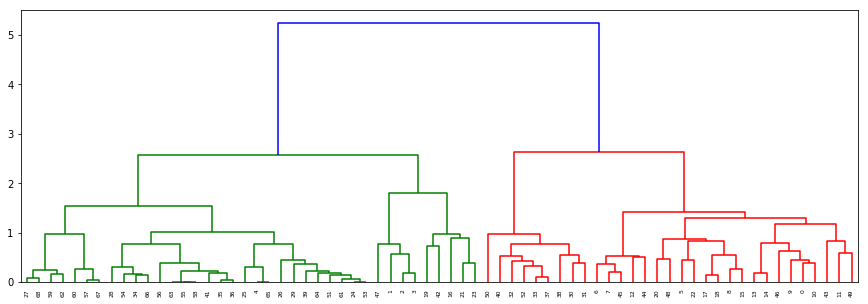

In [47]:
# hierachical clustering
svec = RohG[np.triu_indices(len(RohG),1)]
dist = 1 - svec
n_sbt = 10
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

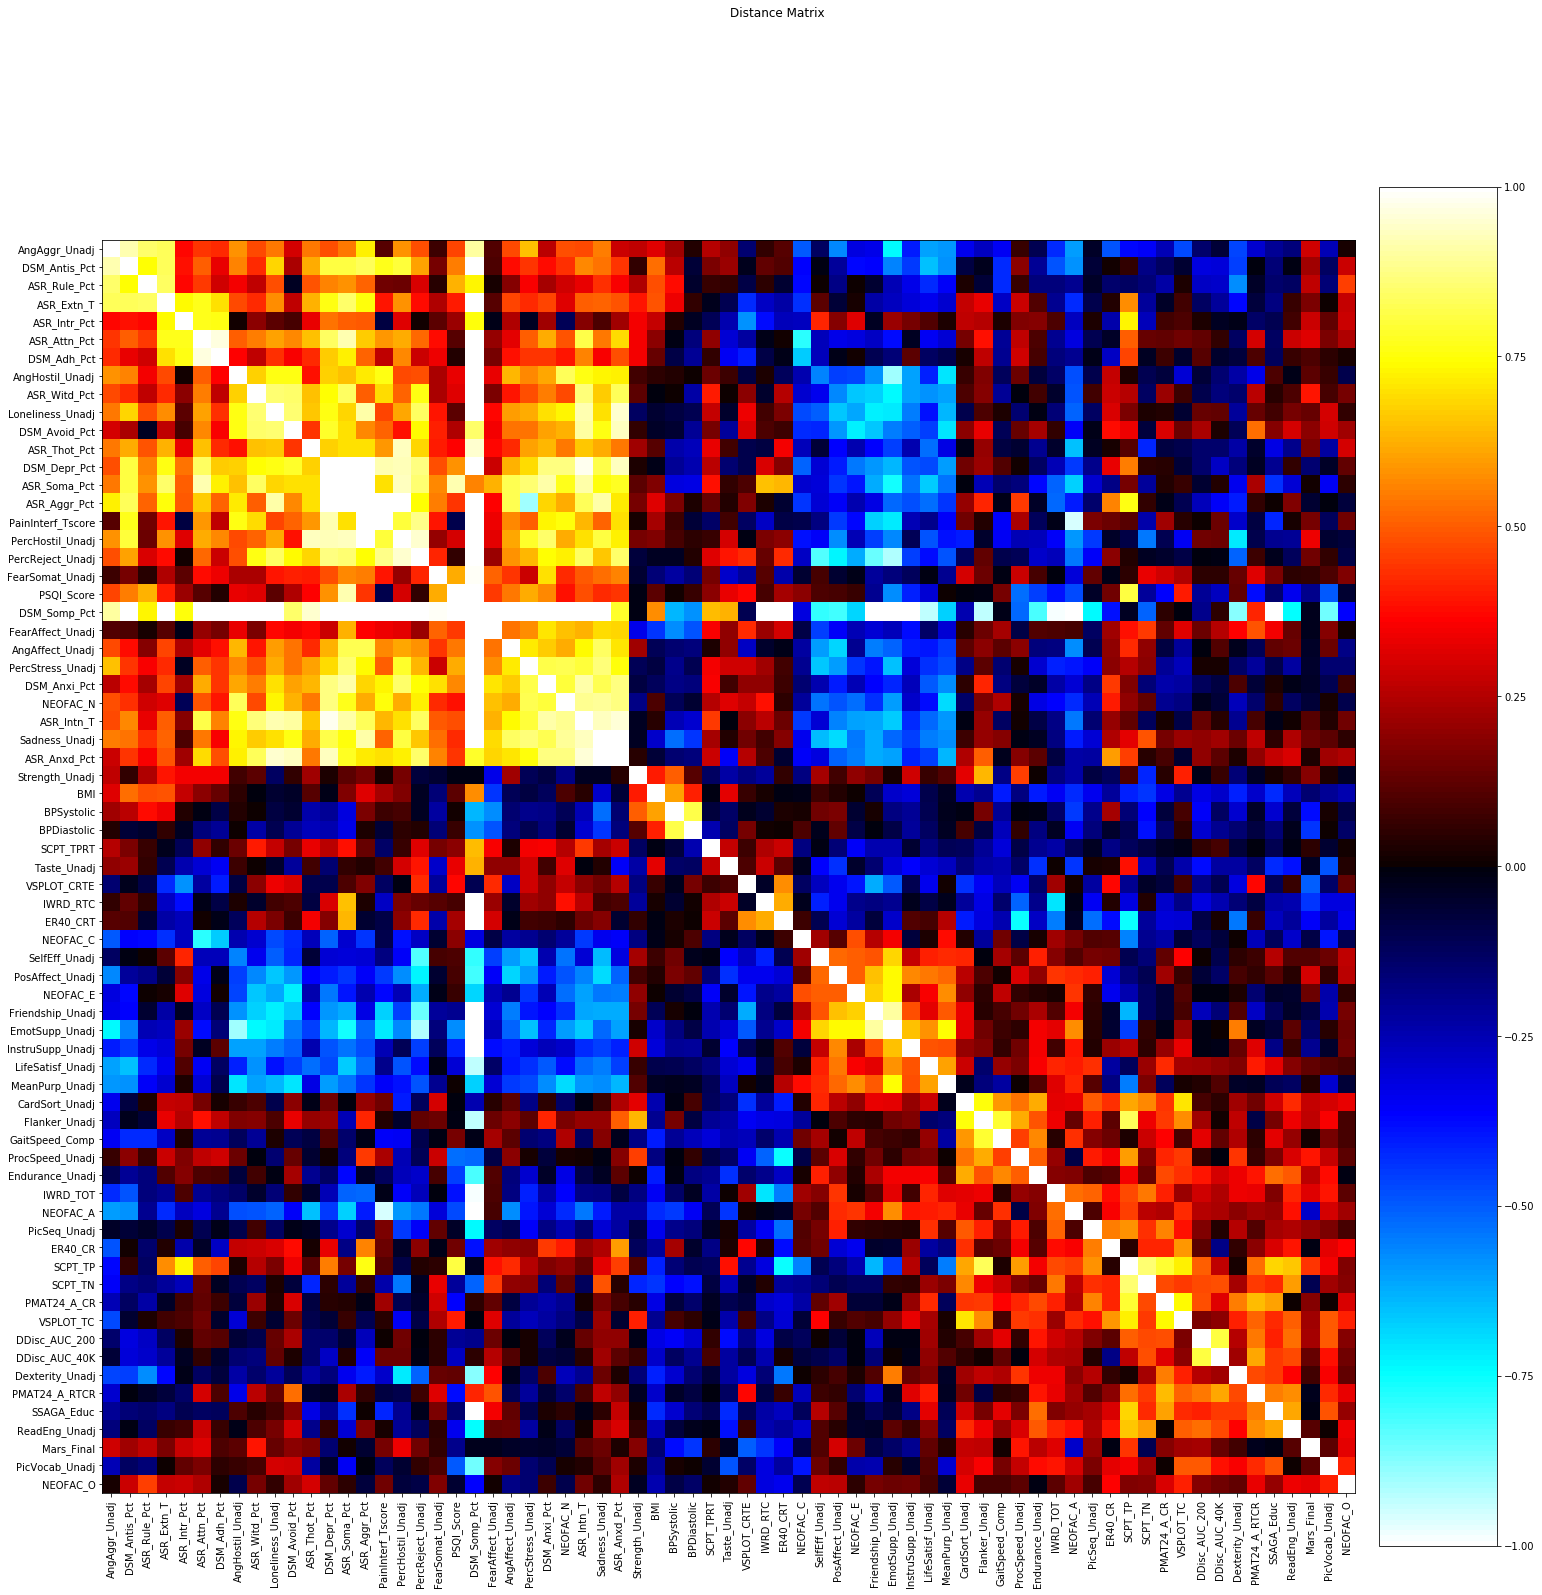

In [48]:
# Plot the distance matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohG[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix')

In [49]:
# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]
RohG_fd_clust = RohG_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

# Set color code
s2_colors = ["#f6afed",
             "#514c82"]

s3_colors = ["#f6afed",
             "#ec8b00",
             "#514c82"]

s4_colors = ["#f6afed",
             "#ec8b00",
             "#514c82",
             "#beb146"]

s5_colors = ["#cb5362",
            "#6ea84e",
            "#9d6cc1",
            "#bb873c",
            "#3fadaf"]

s6_colors = ["#cc5452",
            "#50ac72",
            "#c45ca2",
            "#929d3d",
            "#7879cd",
            "#c8803e"]

s7_colors = ["#bf61bb",
            "#60a75b",
            "#746cc9",
            "#b1963f",
            "#5aa4d1",
            "#cb623f",
            "#c8567a"]

s8_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e"]

s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]


s10_colors =["#8562cc",
            "#60b14d",
            "#c361aa",
            "#bab241",
            "#688bcd",
            "#cd5136",
            "#4bb092",
            "#ca586f",
            "#717e37",
            "#c58443"]


lin2 = LinearSegmentedColormap.from_list(name='s2',
                                         colors = s2_colors,
                                         N=n_sbt)
lin3 = LinearSegmentedColormap.from_list(name='s3',
                                         colors = s3_colors,
                                         N=n_sbt)
lin4 = LinearSegmentedColormap.from_list(name='s4',
                                         colors = s4_colors,
                                         N=n_sbt)
lin5 = LinearSegmentedColormap.from_list(name='s5',
                                         colors = s5_colors,
                                         N=n_sbt)
lin6 = LinearSegmentedColormap.from_list(name='s6',
                                         colors = s6_colors,
                                         N=n_sbt)
lin7 = LinearSegmentedColormap.from_list(name='s7',
                                         colors = s7_colors,
                                         N=n_sbt)
lin8 = LinearSegmentedColormap.from_list(name='s8',
                                         colors = s8_colors,
                                         N=n_sbt)
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                         colors = s9_colors,
                                         N=n_sbt)
lin10 = LinearSegmentedColormap.from_list(name='s10',
                                          colors = s10_colors,
                                          N=n_sbt)

In [50]:
# make strtucture to store different colors parameters
struc = {}
struc["2"]={}
struc["2"]["lin"] = lin2
struc["2"]["s_colors"] = s2_colors
struc["3"]={}
struc["3"]["lin"] = lin3
struc["3"]["s_colors"] = s3_colors
struc["4"]={}
struc["4"]["lin"] = lin4
struc["4"]["s_colors"] = s4_colors
struc["5"]={}
struc["5"]["lin"] = lin5
struc["5"]["s_colors"] = s5_colors
struc["6"]={}
struc["6"]["lin"] = lin6
struc["6"]["s_colors"] = s6_colors
struc["7"]={}
struc["7"]["lin"] = lin7
struc["7"]["s_colors"] = s7_colors
struc["8"]={}
struc["8"]["lin"] = lin8
struc["8"]["s_colors"] = s8_colors
struc["9"]={}
struc["9"]["lin"] = lin9
struc["9"]["s_colors"] = s9_colors
struc["10"]={}
struc["10"]["lin"] = lin10
struc["10"]["s_colors"] = s10_colors

In [51]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(RohG_clust, cuts, 2)
mat_fd, cmat_fd, lmat_fd, ind_fd = make_boxes(RohG_fd_clust, cuts, 2)

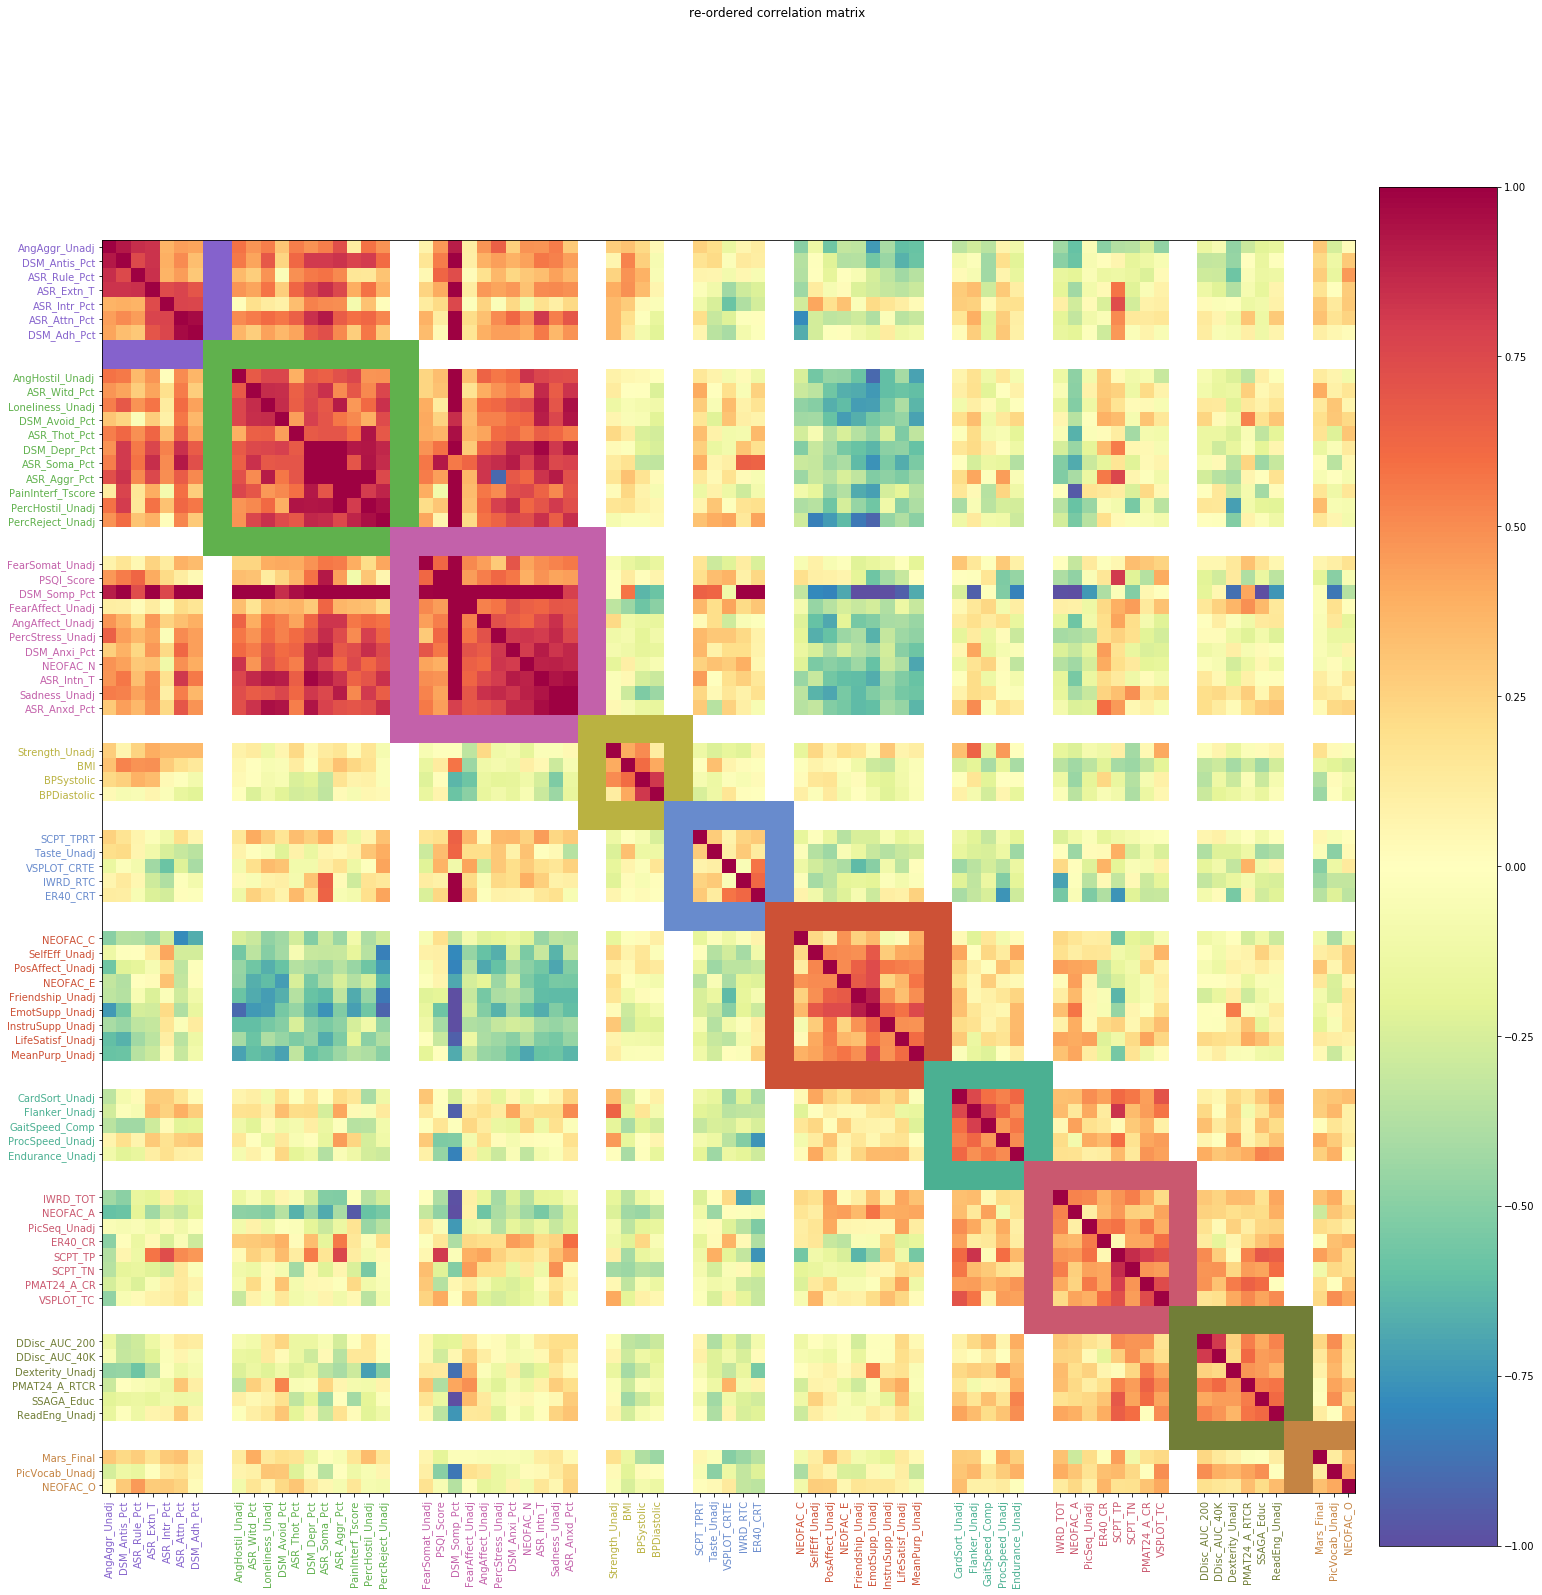

In [52]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered correlation matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

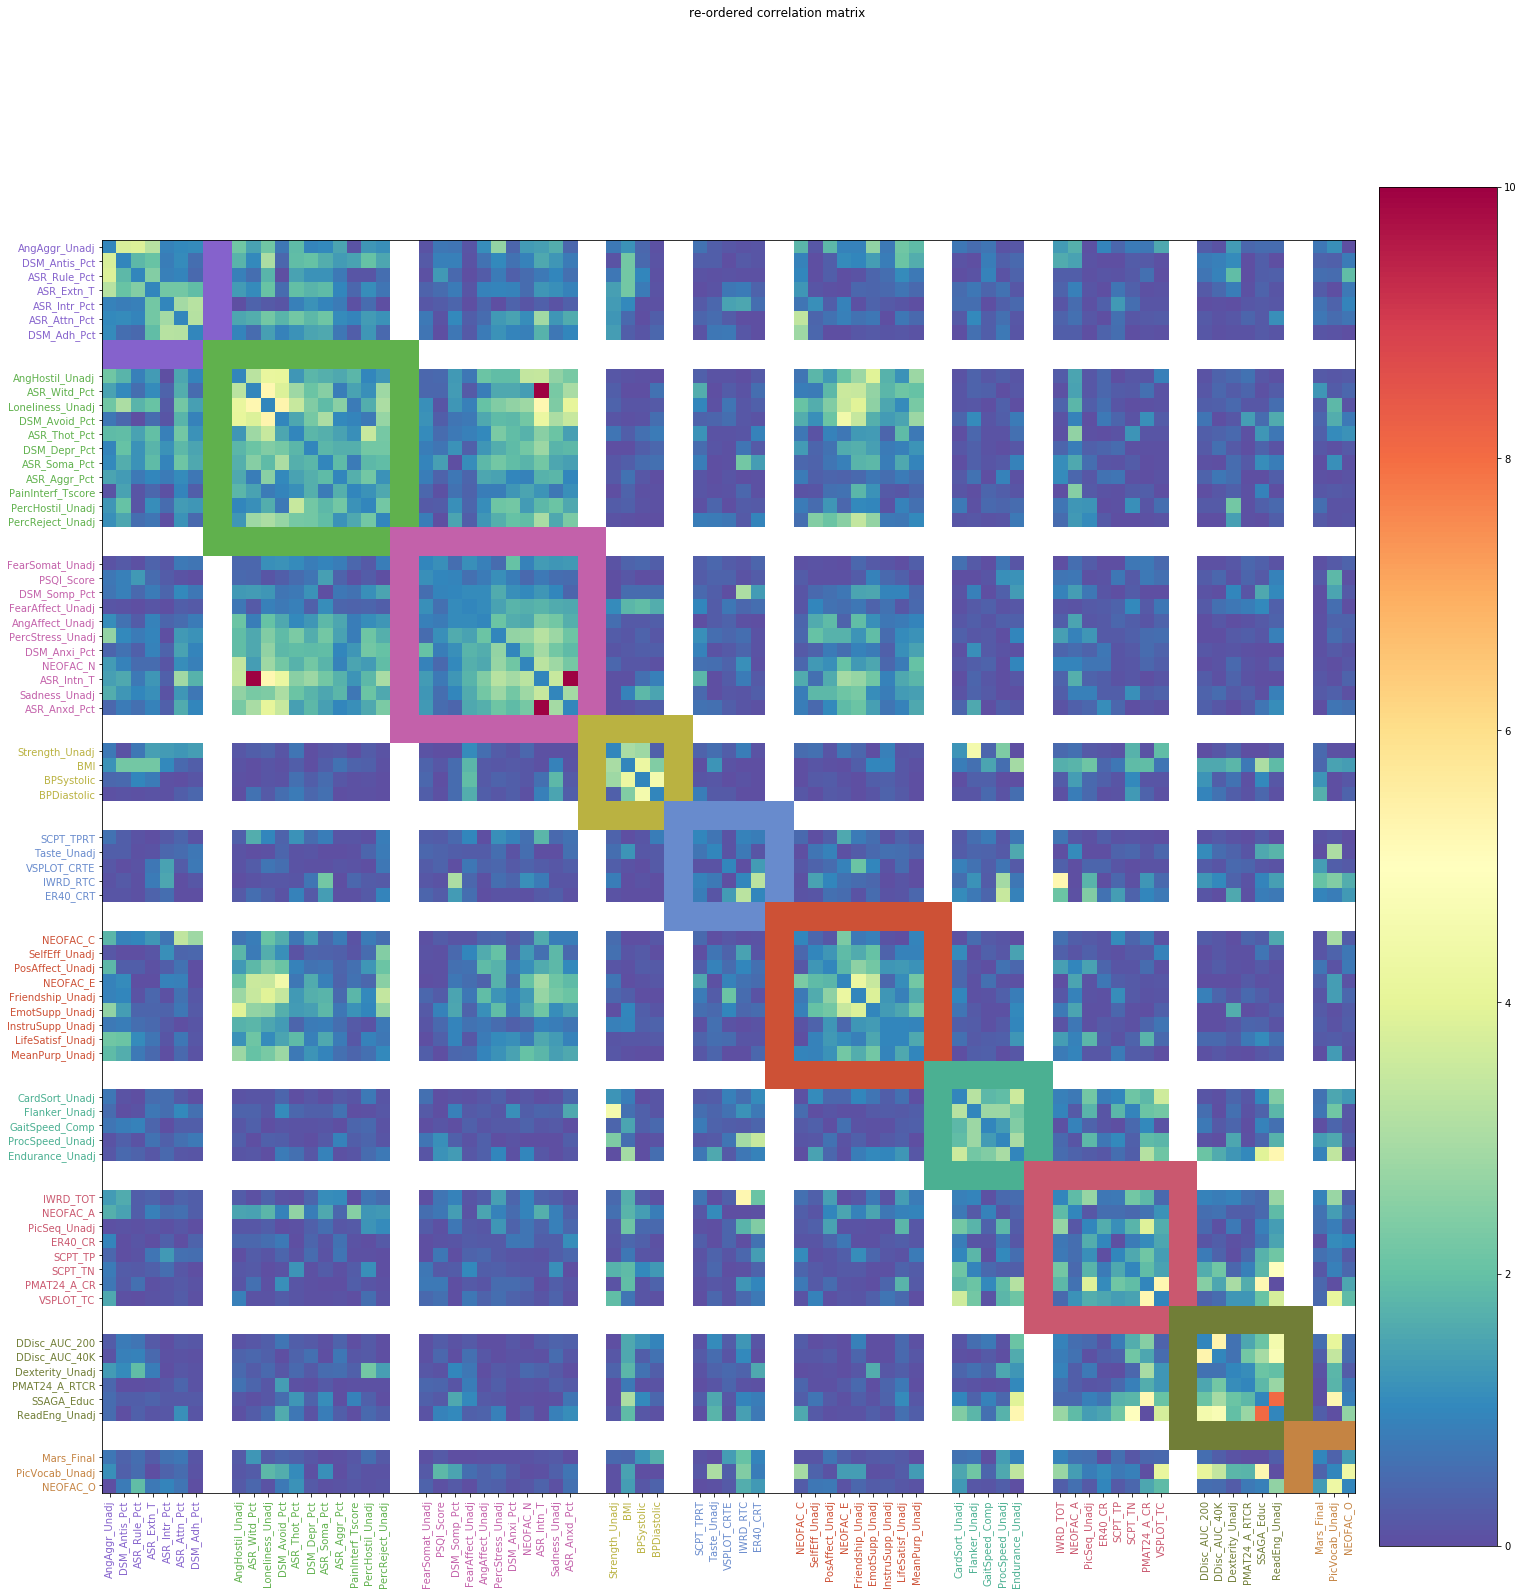

In [53]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered correlation matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

In [24]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))

In [25]:
line

'CONVERGENCE FAILURE\n'

In [18]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))
for i,line in enumerate(fp):
    if 'RhoG is ' in line:
        print(out_dir)
        print(line)
        break

In [19]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))
for i,line in enumerate(fp):
    if 'RhoG is ' in line:
        print(out_dir)
        print(line)
        break
    elif 'CONVERGENCE FAILURE' in line:
        print(out_dir)
        print(line)
        break
fp.close()

LAN_story_sub5_LAN_story_sub4
CONVERGENCE FAILURE



In [24]:
float(line.strip('\n').split(' ')[-1])

ValueError: could not convert string to float: 'FAILURE'

In [170]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))

In [183]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))

In [184]:
for i,line in enumerate(fp):
    if 'RhoG is ' in line:
        print(line)

			 RhoG is 1.0000000



In [179]:
line

'\tFinal models are named poly, spor\n'

In [158]:
number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))

In [159]:
number_lines

32

In [92]:
fp = open(os.path.join(path_root,out_dir,'solar_pleio.out'))
for i,line in enumerate(fp):
    if i == 75 :
        print(line)
        break
fp.close()

			 RhoG is 0.4423606



In [112]:
float(line.strip('\n').split(' ')[-1])

0.4423606

In [174]:
line.find('a')

4

In [6]:
!ls path_root

ls: cannot access 'path_root': No such file or directory


In [1]:
input = ['Duration', 'F0', 'F1', 'F2', 'F3']

In [4]:
dict(zip(input, range(len(input))))

{'Duration': 0, 'F0': 1, 'F1': 2, 'F2': 3, 'F3': 4}

In [103]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
# Set up the paths 
path_root = '/media/yassine/data_disk/Drive/HCP2/'
#path_root = "/home/yassinebha/Drive/HCP/"
subt_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/")
net_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/networks/")
out_path = os.path.join(path_root,"Solar_heritability/HCP_subtype/")

In [5]:
nb_sbt = natural_keys(subt_path)[9]
# task name
task_name = natural_keys(subt_path)[10][5:-1].lower()

In [6]:
task_name

'relational'

In [7]:
# Set up files name
sbt_name_pattern = "sbt_weights_net_{}.csv"
pheno_path = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno/hcp_pheno_{}_raw.csv".format(task_name))
solar_script = 'fcd_solar_h2r_test.sh'
pheno_save = 'solar_{}_spm_pheno.csv'.format(task_name.upper())
pedig_save = 'solar_{}_spm_pedigre.csv'.format(task_name.upper())
solar_out = 'subtype_5_{}_{}'.format(task_name,time.strftime("%d-%m-%Y"))
h2r_out_file = 'h2r_solar_{}_spm_{}.csv'
## Solar covariates
solar_cov = '    cov FD_scrubbed_mean Gender'

In [8]:
# List of network names
list_trial = os.listdir(net_path)
list_trial

['match', 'relation', 'contrast_relation_vs_match']

In [9]:
# Loop over each network and build weight file
for index, trial_name in enumerate(list_trial):
    file_path = os.path.join(net_path, trial_name, sbt_name_pattern.format(trial_name))
    if not os.path.exists(file_path):
        print("Hello, {} does not exist".format(file_path))
    
    tmp_weights = pd.read_csv(file_path)
    # Rename first column
    tmp_weights.rename(columns={" ":"Subject"}, inplace=True)
    tmp_weights.Subject = tmp_weights.Subject.str.strip(" ")
    
    rename_dict = dict()
    for colname in tmp_weights.columns:
        if colname == "Subject":
            continue
        else:
            new_name = "{}_{}".format(trial_name, colname)
            # Get rid of trailing whitespace
            new_name = new_name.strip(" ")
            rename_dict[colname] = new_name

    tmp_weights.rename(columns=rename_dict, inplace=True)
    
    if index==0:
        dataframe = tmp_weights
    else:
        dataframe = pd.merge(dataframe, tmp_weights, on="Subject", how="inner")

In [10]:
dataframe.head()

,Subject,match_sub1,match_sub2,match_sub3,match_sub4,match_sub5,relation_sub1,relation_sub2,relation_sub3,relation_sub4,relation_sub5,contrast_relation_vs_match_sub1,contrast_relation_vs_match_sub2,contrast_relation_vs_match_sub3,contrast_relation_vs_match_sub4,contrast_relation_vs_match_sub5
0,HCP100206,-0.229,0.219,-0.148,-0.105,0.234,0.268,0.313,-0.199,0.263,-0.318,-0.090,0.085,-0.041,-0.085,0.141
1,HCP100307,0.737,-0.722,0.357,0.410,-0.714,-0.259,-0.727,0.296,-0.696,0.734,0.237,0.104,-0.205,-0.050,-0.181
2,HCP100408,-0.488,0.503,-0.347,-0.236,0.471,0.038,0.641,-0.208,0.655,-0.638,-0.226,-0.286,0.366,0.141,0.122
3,HCP100610,-0.119,0.126,-0.048,-0.120,0.136,-0.220,0.261,-0.109,0.379,-0.262,-0.229,-0.504,0.424,0.446,0.027
4,HCP101006,-0.267,0.253,-0.158,-0.143,0.285,0.088,0.527,-0.241,0.518,-0.518,-0.184,-0.061,0.125,0.036,0.154


In [11]:
dataframe.Subject.describe()

count           764
unique          764
top       HCP308129
freq              1
Name: Subject, dtype: object

In [12]:
# Load pheno file
file_weight = dataframe
file_pheno = pd.read_csv(pheno_path)

In [13]:
file_pheno.head()

,Unnamed: 0,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,FD_scrubbed_mean,FD_mean,Subject,Age_in_Yrs,Gender,...,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,HCP100206,0.098646,0.091387,0.118289,0.118289,0.104838,0.108467,HCP100206,27.0,1.0,...,-0.344595,1.283574,0.052662,1.436342,0.706008,-0.510366,1.975280,1.294323,-0.025888,-0.203825
1,HCP100307,0.108372,0.108372,0.098514,0.098514,0.103443,0.103443,HCP100307,27.0,2.0,...,-0.639736,0.522789,-0.952467,-0.713226,-0.559144,-0.140952,-0.703027,0.229112,0.097581,-0.444702
2,HCP100408,0.113633,0.113633,0.145309,0.145309,0.129471,0.129471,HCP100408,33.0,1.0,...,1.173656,0.092160,-0.521888,-0.034026,-0.109229,0.221359,-0.589268,0.357483,-0.039443,0.095913
3,HCP100610,0.184109,0.184109,0.170573,0.160610,0.172360,0.177341,HCP100610,27.0,1.0,...,0.891096,-0.361182,-0.881930,-0.386394,-0.575076,-0.197974,0.203063,0.618868,0.491618,1.343114
4,HCP101006,0.146478,0.146478,0.152041,0.148402,0.147440,0.149260,HCP101006,35.0,2.0,...,0.608381,0.037740,0.055531,-0.883482,-0.383174,-0.309221,-0.753780,-1.183212,0.031989,-0.494022


In [14]:
file_pheno.Subject.describe()

count           797
unique          797
top       HCP567961
freq              1
Name: Subject, dtype: object

In [15]:
# Select a subset of variable
file_pheno_subset = file_pheno[["Subject","Age_in_Yrs","Gender","BMI","FD_mean","FD_scrubbed_mean"]]
file_pheno_subset.head()

,Subject,Age_in_Yrs,Gender,BMI,FD_mean,FD_scrubbed_mean
0,HCP100206,27.0,1.0,26.64,0.108467,0.104838
1,HCP100307,27.0,2.0,22.96,0.103443,0.103443
2,HCP100408,33.0,1.0,27.75,0.129471,0.129471
3,HCP100610,27.0,1.0,36.91,0.177341,0.172360
4,HCP101006,35.0,2.0,30.27,0.149260,0.147440


In [16]:
# Replace gender M=1 and F=2
#file_pheno_subset.Gender.replace({'M':1,'F':2}, inplace=True)
#file_pheno_subset.head()

In [17]:
file_pheno_subset[["Subject"]].describe()

,Subject
count,797
unique,797
top,HCP567961
freq,1


In [18]:
file_weight[["Subject"]].describe()

,Subject
count,764
unique,764
top,HCP308129
freq,1


In [19]:
# Merge weight with subset of pheno variables
merged_weight_pheno = pd.merge(file_weight, file_pheno_subset, on='Subject', how='left')
# Replace 'Subject' by 'ID'
merged_weight_pheno.rename(columns={'Subject':'ID'},inplace=True)
merged_weight_pheno.head()

,ID,match_sub1,match_sub2,match_sub3,match_sub4,match_sub5,relation_sub1,relation_sub2,relation_sub3,relation_sub4,...,contrast_relation_vs_match_sub1,contrast_relation_vs_match_sub2,contrast_relation_vs_match_sub3,contrast_relation_vs_match_sub4,contrast_relation_vs_match_sub5,Age_in_Yrs,Gender,BMI,FD_mean,FD_scrubbed_mean
0,HCP100206,-0.229,0.219,-0.148,-0.105,0.234,0.268,0.313,-0.199,0.263,...,-0.090,0.085,-0.041,-0.085,0.141,27.0,1.0,26.64,0.108467,0.104838
1,HCP100307,0.737,-0.722,0.357,0.410,-0.714,-0.259,-0.727,0.296,-0.696,...,0.237,0.104,-0.205,-0.050,-0.181,27.0,2.0,22.96,0.103443,0.103443
2,HCP100408,-0.488,0.503,-0.347,-0.236,0.471,0.038,0.641,-0.208,0.655,...,-0.226,-0.286,0.366,0.141,0.122,33.0,1.0,27.75,0.129471,0.129471
3,HCP100610,-0.119,0.126,-0.048,-0.120,0.136,-0.220,0.261,-0.109,0.379,...,-0.229,-0.504,0.424,0.446,0.027,27.0,1.0,36.91,0.177341,0.172360
4,HCP101006,-0.267,0.253,-0.158,-0.143,0.285,0.088,0.527,-0.241,0.518,...,-0.184,-0.061,0.125,0.036,0.154,35.0,2.0,30.27,0.149260,0.147440


In [20]:
merged_weight_pheno.ID.describe()

count           764
unique          764
top       HCP308129
freq              1
Name: ID, dtype: object

In [21]:
# Check if there is empty value in BMI
sum(merged_weight_pheno.BMI.isnull())

0

In [22]:
# Save the merged file
merged_weight_pheno.to_csv(os.path.join(out_path,pheno_save), index=False)

In [23]:
os.path.join(out_path,pheno_save)

'/media/yassine/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/solar_RELATIONAL_spm_pheno.csv'

## Build trait file

In [24]:
## build trait file
# Remove not neaded traits
list_trait = merged_weight_pheno.columns.tolist()
new_list = [trait for trait in list_trait if trait not in ['ID','Age_in_Yrs','Gender']]
new_list

['match_sub1',
 'match_sub2',
 'match_sub3',
 'match_sub4',
 'match_sub5',
 'relation_sub1',
 'relation_sub2',
 'relation_sub3',
 'relation_sub4',
 'relation_sub5',
 'contrast_relation_vs_match_sub1',
 'contrast_relation_vs_match_sub2',
 'contrast_relation_vs_match_sub3',
 'contrast_relation_vs_match_sub4',
 'contrast_relation_vs_match_sub5',
 'BMI',
 'FD_mean',
 'FD_scrubbed_mean']

In [25]:
# Save trait file
file_out = open(os.path.join(out_path,"trait_file"), 'w')
for item in new_list:
    file_out.write("%s\n" % item)
file_out.close()

## Build Pedigree file

In [26]:
# Select a subset of variable from pheno file
file_pheno_pedig = file_pheno[["Subject","Twin_Stat","Zygosity","Mother_ID","Gender"]]
file_pheno_pedig.head()

,Subject,Twin_Stat,Zygosity,Mother_ID,Gender
0,HCP100206,NotTwin,NotTwin,56037.0,1.0
1,HCP100307,Twin,NotMZ,51488.0,2.0
2,HCP100408,Twin,MZ,51730.0,1.0
3,HCP100610,Twin,NotMZ,52813.0,1.0
4,HCP101006,Twin,MZ,51283.0,2.0


In [27]:
file_pheno_pedig.Subject.describe()

count           797
unique          797
top       HCP567961
freq              1
Name: Subject, dtype: object

In [28]:
# Build pedigre : ID , mo, fo, hhID, mztwins,sex
mother_id = ["mo_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
father_id = ["fa_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
household_id = ["hh_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
twin_id = ["pair_{}".format(row.Mother_ID) if row.Zygosity == "MZ" else "" for ind, row in file_pheno_pedig.iterrows()]

In [29]:
# write into new data frame
df_pedig = pd.DataFrame()
df_pedig["ID"] = file_pheno_pedig.Subject
df_pedig["fa"] = father_id
df_pedig["mo"] = mother_id
df_pedig["sex"] = file_pheno_pedig.Gender.astype(int)
df_pedig["mztwin"] = twin_id
df_pedig["hhID"] = household_id


print("head")
display(df_pedig.head())
print("tail")
display(df_pedig.tail())
df_pedig.count()

head


,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


tail


,ID,fa,mo,sex,mztwin,hhID
792,HCP992673,fa_56143.0,mo_56143.0,2,,hh_56143.0
793,HCP992774,fa_51345.0,mo_51345.0,1,,hh_51345.0
794,HCP993675,fa_55800.0,mo_55800.0,2,,hh_55800.0
795,HCP994273,fa_52364.0,mo_52364.0,1,,hh_52364.0
796,HCP996782,fa_51541.0,mo_51541.0,2,,hh_51541.0


ID        797
fa        797
mo        797
sex       797
mztwin    797
hhID      797
dtype: int64

In [30]:
# Look for MZ twins missing their co-twin
uniques = list(df_pedig.mztwin.unique())
uniques.pop(0)
twin_counts = [np.sum(df_pedig.mztwin==twin) for twin in uniques]
#for idx, twin in enumerate(uniques):
    #print("{} occurs {} times".format(twin, twin_counts[idx]))

In [31]:
# create a mask that will kepp only MZ twins missing their co-twin
singles = [True if np.sum(df_pedig.mztwin==row.mztwin)==1 else False for ind, row in df_pedig.iterrows()]

In [32]:
# Make a copy of the pedigre to avoid missing up with the original data
copy_df_pedig = df_pedig.copy()

In [33]:
# Select only MZ twins missing their co-twin
df_single_pedig = copy_df_pedig[singles]

# Add "M_" (for missing) to a the single MZ twins
for i, row in df_single_pedig.iterrows():
    df_single_pedig.set_value(i,"ID","M_{}".format(row.ID))
display(df_single_pedig.head())
df_single_pedig.count()

,ID,fa,mo,sex,mztwin,hhID
37,M_HCP110007,fa_54572.0,mo_54572.0,2,pair_54572.0,hh_54572.0
55,M_HCP114823,fa_52925.0,mo_52925.0,2,pair_52925.0,hh_52925.0
82,M_HCP122317,fa_51802.0,mo_51802.0,1,pair_51802.0,hh_51802.0
87,M_HCP123824,fa_56022.0,mo_56022.0,1,pair_56022.0,hh_56022.0
90,M_HCP124422,fa_51529.0,mo_51529.0,2,pair_51529.0,hh_51529.0


ID        43
fa        43
mo        43
sex       43
mztwin    43
hhID      43
dtype: int64

In [34]:
# Append pedgree with fake co-twin for the missing one
df_pedig_final = copy_df_pedig.append(df_single_pedig)
df_pedig_final.head()

,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


In [35]:
df_pedig_final.tail()

,ID,fa,mo,sex,mztwin,hhID
689,M_HCP769064,fa_52803.0,mo_52803.0,1,pair_52803.0,hh_52803.0
716,M_HCP835657,fa_52137.0,mo_52137.0,2,pair_52137.0,hh_52137.0
718,M_HCP837964,fa_52875.0,mo_52875.0,2,pair_52875.0,hh_52875.0
760,M_HCP904044,fa_51290.0,mo_51290.0,2,pair_51290.0,hh_51290.0
784,M_HCP972566,fa_56077.0,mo_56077.0,2,pair_56077.0,hh_56077.0


In [36]:
df_pedig_final.count()

ID        840
fa        840
mo        840
sex       840
mztwin    840
hhID      840
dtype: int64

In [37]:
# Save the pedigree file
df_pedig_final.to_csv(os.path.join(out_path,pedig_save), index=False)

## Run SOLAR heritability estimate 

In [38]:
%%bash -s "$out_path" "$solar_cov" "$solar_script" 
cd $1 #cd to out_path
#sufix=$(echo $2 | sed -e 's/ /_/g') # add a suffix of covariate
sed -i "104s/.*/$2/" $3 # feed the covariate to solar script
sed -i "52s~.*~$1phi2.gz~" $3 # put the right path for the simlink
sed -i "53s~.*~$1pedindex.out~" $3
sed -i "54s~.*~$1pedindex.cde~" $3
sed -i "55s~.*~$1se_univ_polygen.tcl~" $3

In [39]:
%%bash -s "$out_path" "$pedig_save"
cd $1
solar <<INTERNAL_SOLAR_SCRIPT  
load pedi $2
pedigree classes -full
INTERNAL_SOLAR_SCRIPT


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Unloading current pedigree data ...
Loading pedigree data from the file solar_RELATIONAL_spm_pedigre.csv ...
::::::::::::::
mibdrel.tab
::::::::::::::

    NPairs  Relationship
  ========  ===========================================
      1568  Self
       117  Identical sib pair
      1680  Parent-offspring
       586  Siblings
       364  Unrelated



In [40]:
%%bash -s "$out_path" "$pheno_save" "$solar_out"
cd $1
#if [ ! -d $3 ]; then
#   mkdir $3
#fi
solar <<INTERNAL_SOLAR_SCRIPT 
load pheno $2
INTERNAL_SOLAR_SCRIPT
bash fcd_solar_h2r_test.sh trait_file $3 $1$2
for i in $3/Set-*; do bash $i/run_all.sh ; done


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Creating output directories...
00017 : Set-17 : FD_scrubbed_mean                                                  
All done.


## Results

In [41]:
out_herit = pd.read_csv(os.path.join(out_path,solar_out,"se_out.out"),sep="\t",header=None)
out_herit_df =  pd.DataFrame()

data = pd.DataFrame({"Trait": out_herit[2],"H2r": out_herit[4],"P": out_herit[7],"CovVarianceExpl": out_herit[9]})
out_herit_df = data[["Trait","H2r","P","CovVarianceExpl"]].sort_values(['Trait'], ascending=[True]).reset_index(drop=True)
out_herit_df

,Trait,H2r,P,CovVarianceExpl
0,BMI_norm,0.596150,1.609180e-13,0.296816
1,FD_mean_norm,0.243918,1.196360e-02,0.850358
2,contrast_relation_vs_match_sub1_norm,0.097465,7.622840e-02,0.000103
3,contrast_relation_vs_match_sub2_norm,0.152053,2.540930e-02,0.001910
4,contrast_relation_vs_match_sub3_norm,0.142514,2.119550e-02,0.000619
5,contrast_relation_vs_match_sub4_norm,0.100051,1.037657e-01,0.000110
6,contrast_relation_vs_match_sub5_norm,0.086781,1.056090e-01,0.000263
7,match_sub1_norm,0.483234,3.688557e-14,-0.000043
8,match_sub2_norm,0.484474,3.813450e-14,-0.000057
9,match_sub3_norm,0.354013,3.000000e-07,0.010470


In [42]:
# remove unwanted Variables
out_herit_df_clean = out_herit_df[~out_herit_df['Trait'].str.strip().isin(['BMI_norm','FD_mean_norm','FD_scrubbed_mean_norm'])]

In [43]:
# FDR
from statsmodels.sandbox.stats import multicomp as smi
pcorr_vec = smi.multipletests(out_herit_df_clean['P'], alpha=0.05, method='fdr_bh')
out_herit_df_clean.insert(3,'FDR',pcorr_vec[1])
out_herit_df_clean.insert(4,'FDR_log10',-np.log10(pcorr_vec[1]))

In [44]:
out_herit_df_clean

,Trait,H2r,P,FDR,FDR_log10,CovVarianceExpl
2,contrast_relation_vs_match_sub1_norm,0.097465,7.622840e-02,8.795585e-02,1.055735,0.000103
3,contrast_relation_vs_match_sub2_norm,0.152053,2.540930e-02,3.176162e-02,1.498097,0.001910
4,contrast_relation_vs_match_sub3_norm,0.142514,2.119550e-02,2.890295e-02,1.539058,0.000619
5,contrast_relation_vs_match_sub4_norm,0.100051,1.037657e-01,1.056090e-01,0.976299,0.000110
6,contrast_relation_vs_match_sub5_norm,0.086781,1.056090e-01,1.056090e-01,0.976299,0.000263
7,match_sub1_norm,0.483234,3.688557e-14,8.171679e-14,13.087689,-0.000043
8,match_sub2_norm,0.484474,3.813450e-14,8.171679e-14,13.087689,-0.000057
9,match_sub3_norm,0.354013,3.000000e-07,4.500000e-07,6.346787,0.010470
10,match_sub4_norm,0.525551,5.417273e-17,2.708637e-16,15.567249,0.002827
11,match_sub5_norm,0.492009,9.739519e-15,2.921856e-14,13.534341,0.000043


In [45]:
# Loop over trait and create heritability table for radar plot
#drop_list = ['BMI','FD_mean','FD_scrubbed_mean','Handedness']
#list_new = [x for x in new_list if x not in drop_list ]

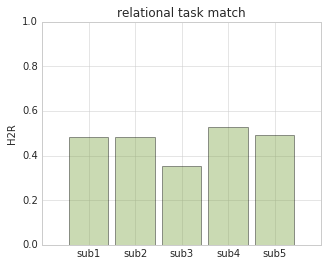

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.483234,0.484474,0.354013,0.525551,0.492009


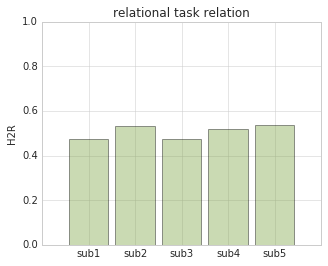

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.472168,0.533172,0.472334,0.519555,0.536545


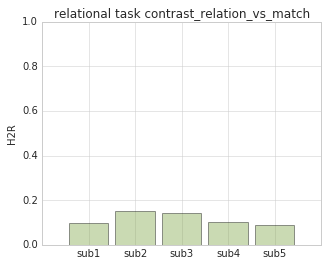

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.097465,0.152053,0.142514,0.100051,0.086781


In [65]:
## Loop over trait and create heritability table for radar plot
#list_trial = [xx.replace('-','_') for xx in list_trial]

list_sbt = ['sub1','sub2','sub3','sub4','sub5']
for trait_herit in list_trial:
    mask_df = [x[:-10] == trait_herit for x in out_herit_df_clean.Trait.str.strip()]
    out_herit_select = out_herit_df_clean[['Trait','H2r']][mask_df]
    # extract trial
    column_net = [' '.join(row['Trait'].split('_')[0:-2]) for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Trial'] = column_net
    # extract subtype
    column_subt = [row['Trait'].split('_')[-2].strip() for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Subt'] = column_subt
    out_herit_clean = out_herit_select[['Trial','Subt','H2r']]
    # Pivot table
    out_herit_final = out_herit_clean.pivot(index='Trial',columns='Subt',values='H2r')
    out_herit_final.index.name=None
    out_herit_final.rename(index={column_net[1]: 'H2R'},inplace= True)
    #put 0 for non for empty heritabity
    for ii in list_sbt:
        if ii not in out_herit_final.columns.get_values():
            out_herit_final.loc[:,ii]=0
    out_herit_final=out_herit_final[list_sbt]
    out_herit_final.to_csv(os.path.join(out_path,solar_out,h2r_out_file.format(task_name,trait_herit)))
    # H2R bar plot
    fig,ax = plt.subplots(figsize=(5, 4))
    y_pos = np.arange(len(out_herit_final.columns))
    ax.bar(y_pos,out_herit_final.ix['H2R'],color="#7ca343",alpha=0.4,align = 'center',width=0.85)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(list_sbt)
    ax.set_ylim(0,1)
    ax.set_ylabel('H2R')
    #ax.grid(False)
    plt.title('{} task {}'.format(task_name,trait_herit))
    plt.show()
    fig.savefig(os.path.join(subt_path,"{}_barplot_heritability.svg".format(trait_herit)))
    display(out_herit_final)

In [47]:
##### R section #########

In [48]:
# first on terminal install cairo : "sudo apt install libcairo2-dev"
# devtools::install_github("hadley/svglite")
# devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)
import warnings
warnings.filterwarnings('ignore')

In [49]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

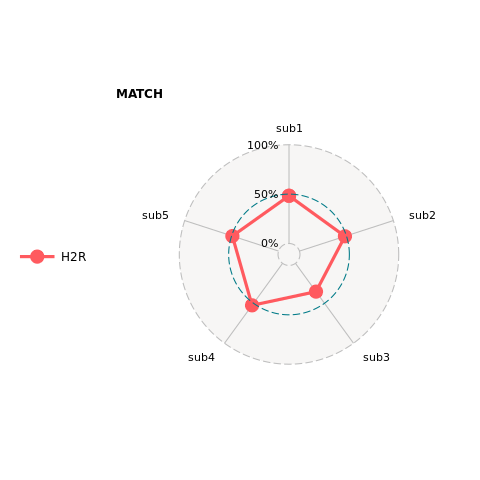

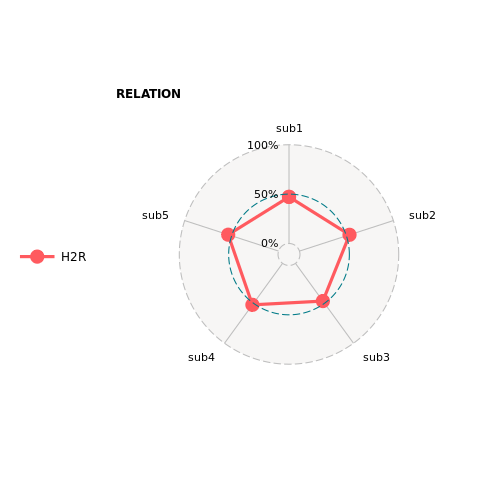

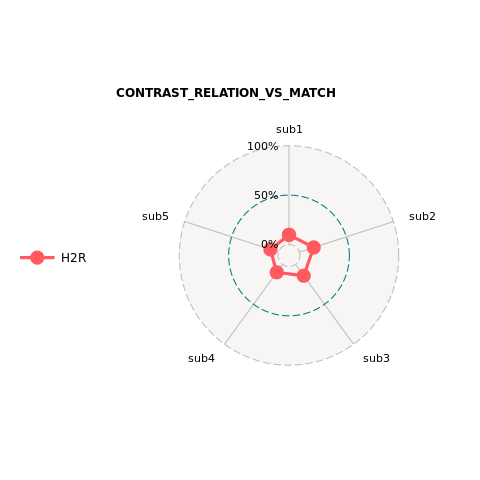

In [50]:
%%R -i out_path,solar_out,task_name,list_trial,path_root
for (ii in list_trial) {
    MyData <- read.csv(file=paste(out_path,solar_out,"/h2r_solar_",task_name,'_spm_',ii,'.csv',sep = ''))
    # plot radar 
    image=ggradar(MyData, grid.min = 0,
                  grid.mid = 0.5, 
                  grid.max = 1, 
                  axis.label.size = 4, 
                  grid.label.size = 5 ,
                  legend.text.size =5) +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' \n  ',toupper(ii),sep = ''))
    ggsave(file=paste(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/" ,ii,"_heritability.svg",sep = ''), plot=image, width=10, height=8)
    print(image)
     }